In [1]:
import json
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from umap import UMAP
import os
import torch
import re
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\bin_l\anaconda3\envs\MIS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"目前使用的設備是: {device}")

目前使用的設備是: cuda


In [3]:
def clean_text(text):
    # 1. 移除網址 (http, https, ftp, www)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # 2. 移除一些社群常見的雜訊 (可選)
    # 例如：移除重複的換行或多餘空格
    text = text.replace('\n', ' ').strip()
    return text

In [4]:
##############
# Read data
##############

platform_name = "dcard"
input_file_name = "dcard_comments_by_keyword.json"

with open(input_file_name, "r", encoding="utf-8") as f:
    fb_comments_dict = json.load(f)
print(f"成功從{input_file_name}讀取檔案至fb_comments_dict\n")


print()

# 將全部留言存到all_comments
all_comments = []
for artist in fb_comments_dict:
    if artist == '張書偉' or artist == '陳柏霖':
        continue
    all_comments += fb_comments_dict[artist]
    print(artist)
    
print()

# 刪掉url
all_comments_cleaned = [clean_text(str(c)) for c in all_comments if len(clean_text(str(c))) > 2]
print("成功將所有留言存入all_comments_cleaned，並去除留言內的url\n")
print(f"all_comments_cleaned共有{len(all_comments_cleaned)}篇貼文")

成功從dcard_comments_by_keyword.json讀取檔案至fb_comments_dict


王大陸
坤達
修杰楷
阿達
小杰
陳零九

成功將所有留言存入all_comments_cleaned，並去除留言內的url

all_comments_cleaned共有2268篇貼文


In [10]:
############
# Settings
############

# 1. 向量化模型 (使用多語言支援)
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# 2. 降維模型 (UMAP): 影響分群的精細度
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# 3. 聚類模型 (HDBSCAN): 自動偵測分群
# min_cluster_size: 一個主題最少要有幾則留言 (可根據資料量調整)
min_size = 10
hdbscan_model = HDBSCAN(min_cluster_size=min_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 4. 關鍵字提取 (Vectorizer): 排除停用詞
vectorizer_model = CountVectorizer(stop_words=["的", "了", "在", "是", "我", "https", "com"])

print(f"設定元件完畢{min_size}")

設定元件完畢10


In [11]:
#############
# Training
#############
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(all_comments_cleaned)

2025-12-25 05:24:51,745 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 71/71 [00:01<00:00, 62.12it/s]
2025-12-25 05:24:52,902 - BERTopic - Embedding - Completed ✓
2025-12-25 05:24:52,902 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-25 05:24:58,585 - BERTopic - Dimensionality - Completed ✓
2025-12-25 05:24:58,586 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-25 05:24:58,636 - BERTopic - Cluster - Completed ✓
2025-12-25 05:24:58,638 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-25 05:24:58,671 - BERTopic - Representation - Completed ✓


In [12]:
# 將離群值分配給最相似的主題
new_topics = topic_model.reduce_outliers(all_comments_cleaned, topics)

# 更新模型中的主題標籤
topic_model.update_topics(all_comments_cleaned, topics=new_topics)

100%|██████████| 1/1 [00:00<00:00, 101.53it/s]
2025-12-25 05:24:58,790 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [13]:
###################
# Display Results
###################

# 取得主題清單 (-1 代表雜訊/不屬於任何主題)
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

# 儲存結果
topic_info.to_csv(f"hdbscan_topics_{platform_name}_overlap.csv", index=False, encoding="utf-8-sig")


   Topic  Count                                               Name  \
0     -1    495                      -1_我站崗風吹褲擺_很好啊_前線衝鋒我無畏_應該早點爆阿   
1      0    313                           0_有買的快退票_卻不能當兵_3年的_避風頭而已   
2      1    182                  1_加油_沒事_他們根本有恃無恐_台灣人真的很健忘台灣人真的很包容   
3      2    153  2_大平台被爆出來的時候就應該自首了吧_是覺得要賭賭看會不會被查到嗎_而不是等他來查_感覺他...   
4      3     73                        3_坤達love_you_坤達帥多了_大根涉逃兵發聲了   
5      4     63                                    4_乾好帥_另外_認真說_西裝   
6      5     57                   5_蔣萬安_林昶佐_政治人物也查一查阿_這些政治人物是不是也要查   
7      6     61                      6_逃兵_役男會服氣的_兵不夠就該召台女服義務役了_喔是喔   
8      7     43                               7_王大陸最盤_王大陸_www_king   
9      8     41  8_一波合體賺飽了以前賺不夠分的錢_棒棒堂還因此也學人家合體_結果主持節目還莫名其妙拿獎_王...   

                                      Representation  \
0  [我站崗風吹褲擺, 很好啊, 前線衝鋒我無畏, 應該早點爆阿, 只是躲輿論壓力而已, 到時候...   
1  [有買的快退票, 卻不能當兵, 3年的, 避風頭而已, 還不是都活著回來還孕育你我, 連跑步...   
2  [加油, 沒事, 他們根本有恃無恐, 台灣人真的很健忘台灣人真的很包容, 反正風頭過了, 明...   
3  [大

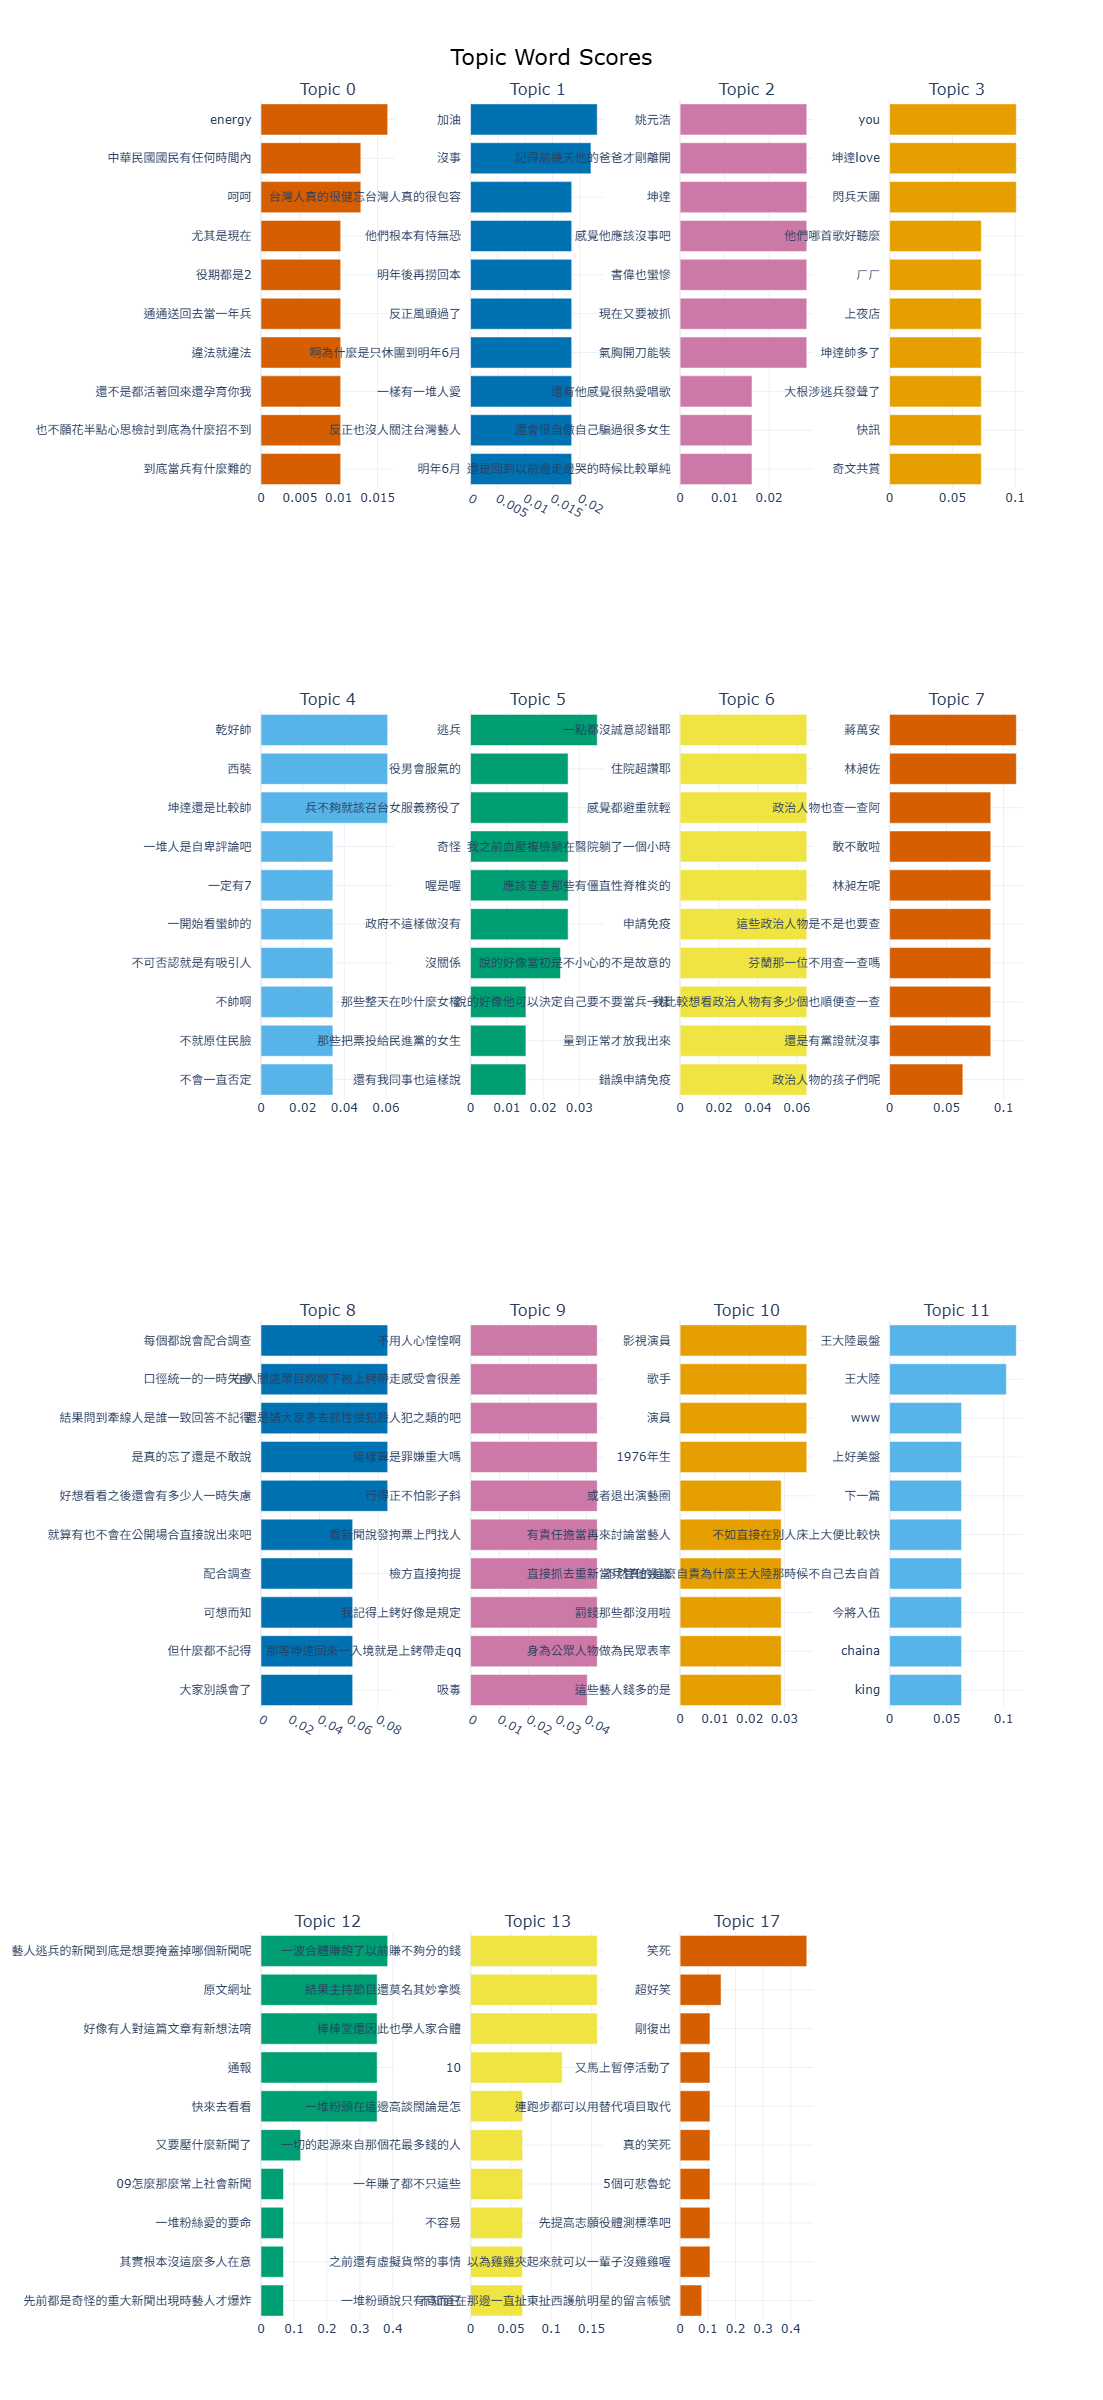

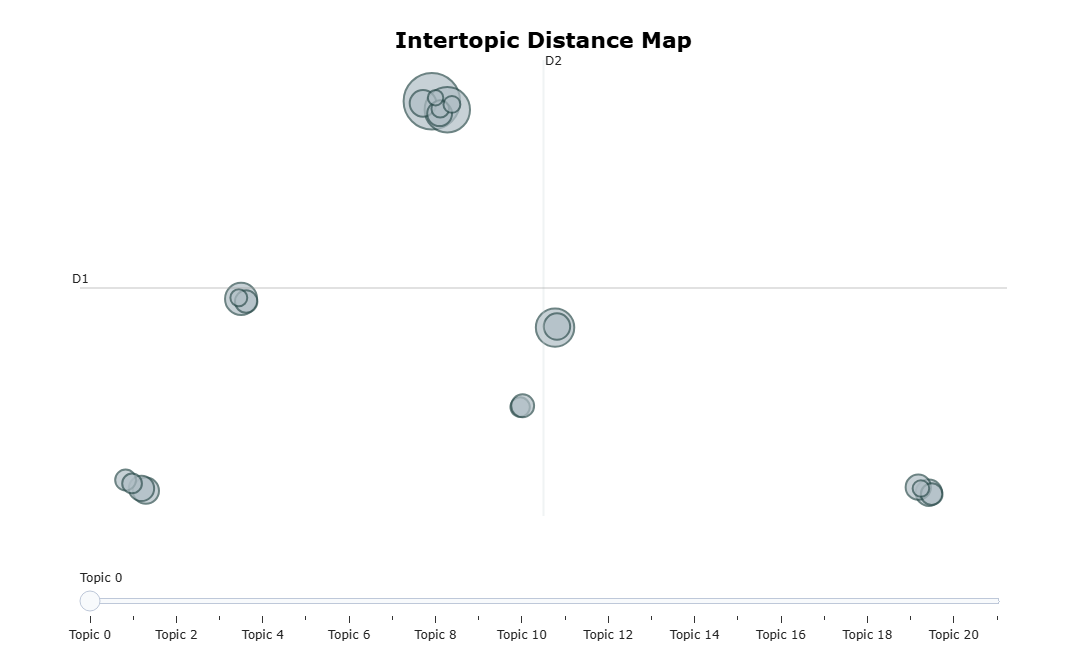

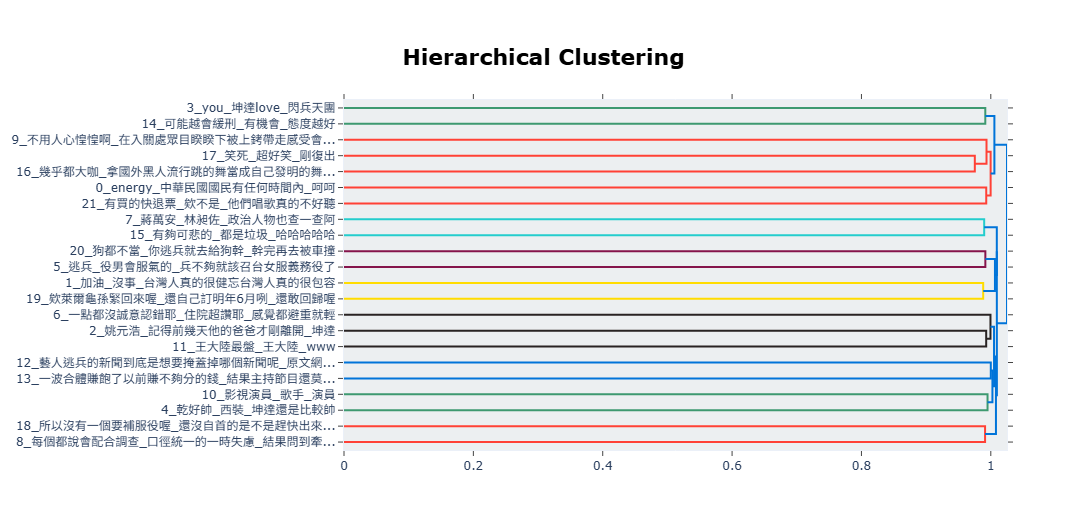

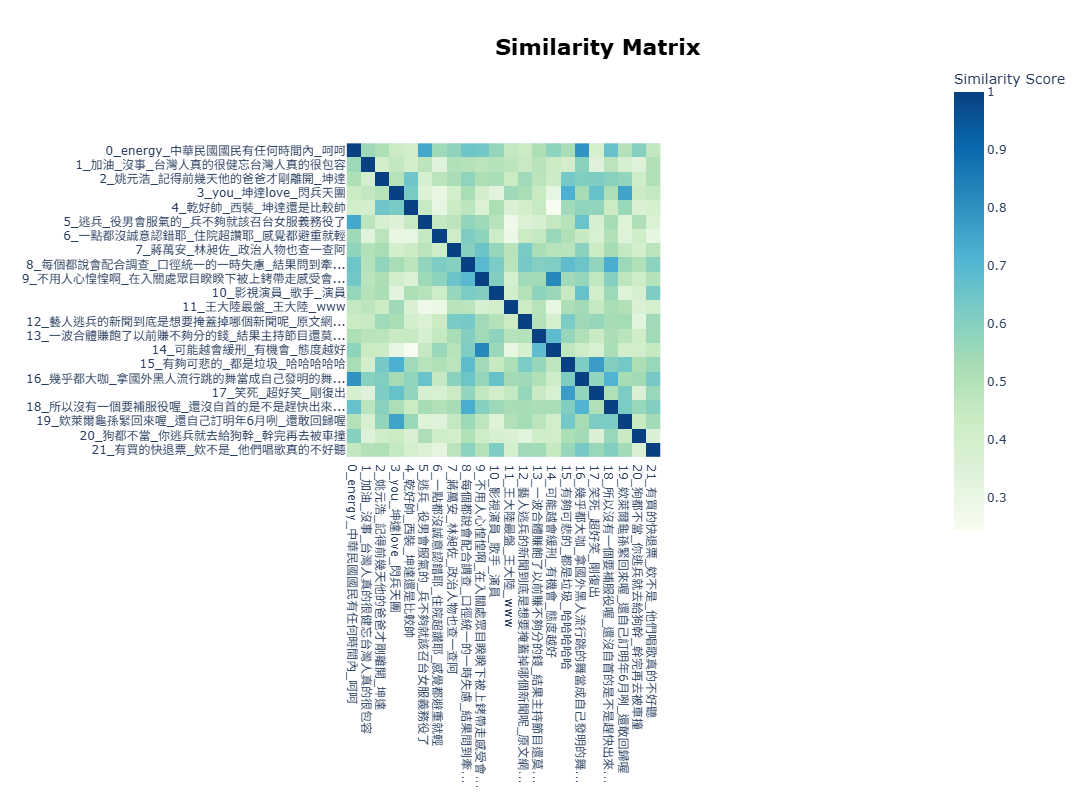

In [9]:
###############
# 圖形化顯示
###############

# top_n_topics: 顯示前幾個主題
# n_words: 每個主題顯示幾個關鍵字
fig1 = topic_model.visualize_barchart(top_n_topics=15, n_words=10, height=600)
fig1.show()

# 儲存為 HTML 檔（可以用瀏覽器開啟，保留互動功能）
fig1.write_html(f"topic_barchart_{platform_name}_overlap.html")

# intertopic distance map
fig2 = topic_model.visualize_topics()
fig2.show()
fig2.write_html(f"topic_distance_map_{platform_name}_overlap.html")

# Hierarchy
fig3 = topic_model.visualize_hierarchy()
fig3.show()
fig3.write_html(f"topic_hierarchy_{platform_name}_overlap.html")

# Heat Map
fig4 = topic_model.visualize_heatmap()
fig4.show()
fig4.write_html(f"topic_heatmap_{platform_name}_overlap.html")